In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import csv
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
import random
from transformers import CLIPTextModel, CLIPTokenizer
import argparse
from torchvision import transforms
import cv2 as cv
from matplotlib import pyplot as plt

/home/ricardo/miniconda3/envs/dreambooth/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Vanilla prompt

We want to extract specific information from the general csv metadata file. This can be done by creating a function taht takes the folder of interest as input, creates a csv fuile with the contents of the fgolder (filenames) and then creates a new metadata csv using just the names of the filenames csv and lookiing for the ids in the general metadat csv.

In [2]:
def create_folder_csv(folder_dir:Path, image_extension: str):
    """Creates a csv file with the name of the files in the folder with specific extension.

    Args:
        folder_dir (Path): images folder
        image_extension (str): png, jpg, etc.
    """
    # get folder name from directory
    folder_name = folder_dir.name
    # check if the csv file with the filenames already exists
    csv_path = folder_dir.parent.parent / 'filenames' / f'{folder_name}.csv'
    if not csv_path.exists(): # if not, create it
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            for filename in os.listdir(folder_dir):
                if filename.endswith(f".{image_extension}"):
                    writer.writerow([filename])
    return csv_path

def subset_csv(files_folder:Path, reference_folder:Path):
    """creates subset coming from the ids of the files in the files folder with reference to the referencer folder

    Args:
        files_folder (Path): files folder
        reference_folder (Path): reference folder
    """
    csv_path = create_folder_csv(files_folder, 'png') # create name csv if it does not exist
    # open csv file
    name_csv = pd.read_csv(csv_path, header=None)
    # set column name as filename
    name_csv.columns = ['filename']
    # remove extension in all filenames in name_csv (for comperison with general metadata)
    name_csv['filename'] = name_csv['filename'].str.replace('.png', '', regex=True)
    # open general metadata csv file
    general_csv = pd.read_csv(reference_folder, header=0)
    # create new csv only with the filenames in the folder
    new_csv = general_csv[general_csv['image_id'].isin(name_csv['filename'])]
    # save new csv
    save_path = files_folder.parent.parent / 'metadata' / f'{files_folder.name}.csv'
    new_csv.to_csv(save_path, index=False)
    
    return save_path

In [43]:
# create subset csv
folder_name = 'breast10p_RGB'
files_folder = repo_path / 'data/images' / f'{folder_name}'
reference_folder = repo_path / 'data/metadata/metadata_Hologic.csv'
metadata_path = subset_csv(files_folder, reference_folder)

In [102]:
# read csv file
metadata = pd.read_csv(metadata_path, header=0)
# get df with only two columns
metadata = metadata[['image_id', 'view_position']]
# add exension to the end of the image_id
metadata['image_id'] = metadata['image_id'].astype(str) + '.png'
# change image_id to file_name
metadata = metadata.rename(columns={'image_id': 'file_name'})
# prompt column must contain 'mammogram' plus the view position
metadata['prompt'] = 'mammogram, ' + metadata['view_position'] + ' view'
# remove view_position column
metadata = metadata.drop(columns=['view_position'])
# transform to json
metadata = metadata.to_json(orient='records', lines=True)
# use same folder as files folder
json_path = files_folder / 'metadata.jsonl'
# save json
with open(json_path, 'w') as f:
    f.write(metadata)

# Analyze stable diffusion dataset

In [112]:
args = {
    'pretrained_model_name_or_path': "runwayml/stable-diffusion-v1-5",
    'revision': 'fp16',
    'resolution': 512,
    'train_batch_size': 1,
    'dataloader_num_workers': 0,
}
# transform in namespace
args = argparse.Namespace(**args)

tokenizer = CLIPTokenizer.from_pretrained(
        args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision
    )

Here you are getting the data, rwa if you want to call it like that.
- Image: original input (RGB, grayscale, etc.) with no preprocessing
- Prompt: pure string text before tokenization.

In [107]:
# load dataset, with metadata inside files folder
data_files = {}
data_files["train"] = os.path.join(files_folder, "**")
dataset = load_dataset(
    "imagefolder",
    data_files=data_files,
)
column_names = dataset["train"].column_names
image_column = column_names[0]
caption_column = column_names[1]

Resolving data files:   0%|          | 0/4060 [00:00<?, ?it/s]

Using custom data configuration default-586a7e4a7bbb73c1
Found cached dataset imagefolder (/home/ricardo/.cache/huggingface/datasets/imagefolder/default-586a7e4a7bbb73c1/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Here both raw data are transformed ot be processed by the model
- Image: resized, croped and normalized to be in diffusion ranges (-1,1)
- Prompt: tokenized and truncated to have max length

In [108]:
def tokenize_captions(examples, is_train=True):
    """from the example dictionary, it takes the caption from the caption column and returns the tokenized input ids

    Args:
        examples (dict): example dict with image and caption
        is_train (bool, optional): for multiple caption, randomize it. Defaults to True.

    Raises:
        ValueError: wring prompt type

    Returns:
        tensor: tokenized input ids, max length per prompt 77 tokens
    """
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption) # append indiivdual 
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(
        captions, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
    )
    return inputs.input_ids

# Preprocessing the datasets.
train_transforms = transforms.Compose(
    [
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)
# preprocessing function to give to the dataloader
def preprocess_train(examples):
    """preprocess examples to store the pixel values and the tokenized input ids

    Args:
        examples (dict): example dictionary with image and caption

    Returns:
        dict: trnsformed images and tokenized input ids
    """
    images = [image.convert("RGB") for image in examples[image_column]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)
    return examples

# Set the training transforms
train_dataset = dataset["train"].with_transform(preprocess_train)

Finally define collator and send everything to dataloader

In [115]:
def collate_fn(examples):
    """basically stacks the batches into a single batch

    Args:
        examples (dict): example dictionary with image and caption

    Returns:
        dict: final dataloader batch
    """
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example["input_ids"] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids}

# DataLoaders creation:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=args.train_batch_size,
    num_workers=args.dataloader_num_workers,
)
batch = next(iter(train_dataloader))

# Analyze dreambooth dataset

In [ ]:
class DreamBoothDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        class_num=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError(f"Instance {self.instance_data_root} images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir()) # get all the images paths in the folder
        self.num_instance_images = len(self.instance_images_path) # number of images in the folder
        self.instance_prompt = instance_prompt # prompt for the instance images
        self._length = self.num_instance_images # length of the dataset

        if class_data_root is not None: # if there are prior images
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True) # create the folder if it doesn't exist
            self.class_images_path = list(self.class_data_root.iterdir()) # get paths of all the class images
            if class_num is not None: # class number. This can vary if there are more images in the folder and we only want to use a subset of them
                self.num_class_images = min(len(self.class_images_path), class_num)
            else:
                self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images) # length of the dataset will be the max of the number of instance images and the number of class images
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose( # classic image transforms for diffusion models
            [ # resize images to squares with ration preservation, then normalize -1 to 1
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length # length of the dataset is the max of the number of instance images and the number of class images

    def __getitem__(self, index):
        """returns example dictionary

        Args:
            index (int): index of the example

        Returns:
            dict: example dictionary with keys "instance_images", "instance_prompt_ids", "class_images", "class_prompt_ids"
        """
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images]) # instance images as module in case there are more class images than instance images
        if not instance_image.mode == "RGB": # convert to RGB if not already
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image) # instance images
        example["instance_prompt_ids"] = self.tokenizer( # tokenize the prompt
            self.instance_prompt,
            truncation=True, # max 77 tokens
            padding="max_length", # pad to max length
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        if self.class_data_root: # if there are class images
            class_image = Image.open(self.class_images_path[index % self.num_class_images]) # same idea as above
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                truncation=True,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                return_tensors="pt",
            ).input_ids

        return example

# Promt Generation

## Area

The idea would be to check first if from the histogram we can assume the area of the breast inderectly coming from the number of black pixels

### Black pixels couting

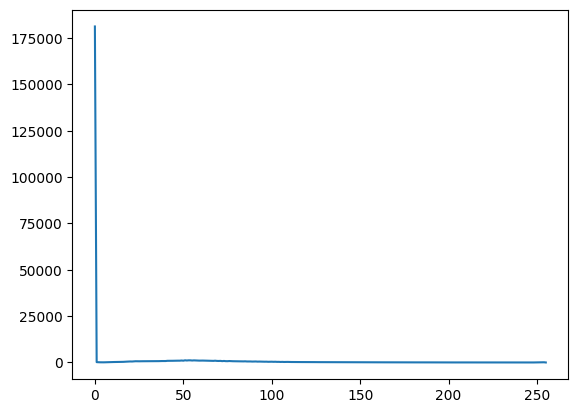

In [21]:
# read paths csv
folder_name = 'breast10p_RGB'
im_num = 0

paths_csv = repo_path / f'data/filenames/{folder_name}.csv'
im_path = pd.read_csv(paths_csv, header=None)[0].values[im_num]
img_path = repo_path / 'data/images/breast10p_RGB' / f'{im_path}'
# read image as numpy array (remember image has 3 identical gray channels)
img = cv.imread(str(img_path))[:,:,0]
# get img histogram
hist = cv.calcHist([img],[0],None,[256],[0,256])
# show
plt.figure()
plt.plot(hist)

We will assume that only the 0 pixels are from the background. Let's take a look at the mask generated by this pixels

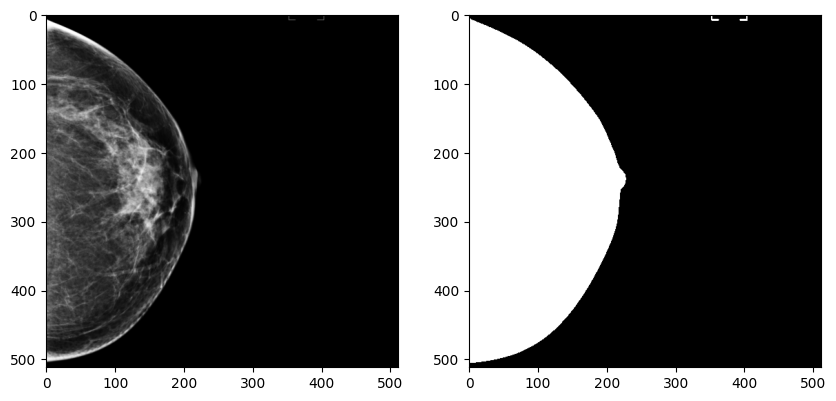

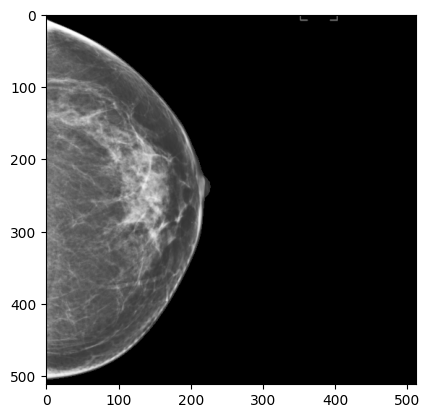

In [22]:
zero_pixels = np.where(img == 0)
# create binary mask of the zero pixels
mask = np.zeros(img.shape, dtype=np.uint8)
mask[zero_pixels] = 1
# invert mask
mask = 1 - mask
# show in row
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(mask, cmap='gray')
# plot the mask over the image
plt.figure()
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='gray', alpha=0.2)

The masking is successful, now we can use this mask to get the area of the breast

In [23]:
# total area
total_area = img.shape[0] * img.shape[1]
# breast area
breast_area = np.sum(mask)
# breast percentage
breast_percentage = breast_area / total_area
print(f'breast percentage: {breast_percentage}')

breast percentage: 0.3084716796875


### Decide prompt based on area

Given the mask and the porcentage area, we should divide the area in two or three main groups.

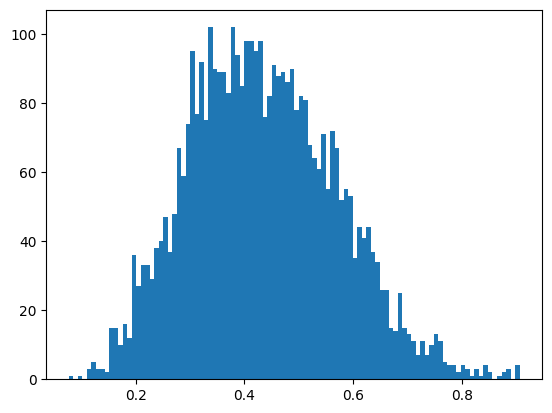

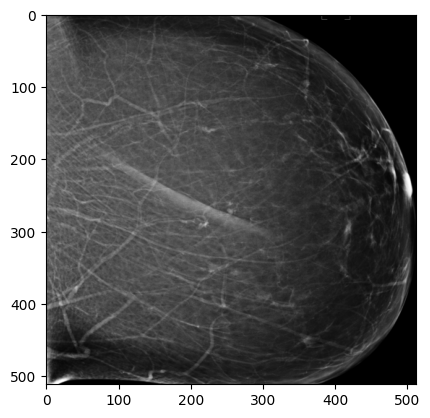

In [40]:
# Let's check the area distribution
# read area csv
area_pd = pd.read_csv(repo_path / 'data/metadata/area_breast10p_RGB.csv')
area_pd
# plot histogram
plt.figure()
plt.hist(area_pd['breast_percentage'], bins=100)

# get smallest area id
min_area_id = area_pd['breast_percentage'].idxmax()
min_im = area_pd.iloc[min_area_id]
# show image
img_path = repo_path / 'data/images/breast10p_RGB' / f'{min_im["id"]}'
img = cv.imread(str(img_path))[:,:,0]
plt.figure()
plt.imshow(img, cmap='gray')